# EDA & Feature Selection: Titanic-Spaceship <span style="color:orange">**Competition**</span>
<img src="../assets/spaceship-pic.jpg" alt="Title-Pic">

# Imports

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from pandas import Series, DataFrame
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE


np.set_printoptions(suppress=True)

sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
sns.set_palette("Set2")

# Data

In [252]:
df_raw_data = pd.read_csv("../data/data.csv")
df = df_raw_data.copy()
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Helper Functions & Constants

In [253]:
# Columns
PID = "PassengerId"
HOME_PLANET = "HomePlanet"
CRYO_SLEEP = "CryoSleep"
CABIN = "Cabin"
DESTINATION = "Destination"
AGE = "Age"
VIP = "VIP"
ROOM_SERVICE = "RoomService"
FOOD_COURT = "FoodCourt"
SHOPPING_MALL = "ShoppingMall"
SPA = "Spa"
VR_DECK = "VRDeck"
NAME = "Name"
TRANSPORTED = "Transported"

# Constants
TARGET = "Target"

TRUE_FALSE_MAP = {False: 0, True: 1}


In [254]:
def plot_target_relation(column_name):
    #_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    #ax1, ax2 = axes
    
    target_pvt = df.pivot_table(index=column_name, values=TARGET, aggfunc="mean").sort_index()

    #sns.pointplot(x=TRANSPORTED, y=column_name, data=df, ax=ax1, order=["Poor", "Standard", "Good"]).set_title(f"Relation Credit-Score and {column_name}")
    sns.regplot(x=target_pvt.index, y=target_pvt.to_numpy(), ci=False, line_kws={"color": "C1"}, scatter_kws={"alpha": 0.5}).set_title(f"Linear Relation Transported and {column_name}")

In [255]:
def plot_target_relation_cat(column_name):
    g = sns.pointplot(x=column_name, y=TARGET, data=df)
    g.set_title(f"Relation Transported and {column_name}")
    g.tick_params(axis='x', rotation=45)

In [256]:
def plot_dist(column_name):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    ax1, ax2 = axes
    
    title = f"Distribution of {column_name}"
    ax1.set_title(title)
    ax2.set_title(title)

    sns.boxplot(x=column_name, data=df, ax=ax1)
    df[column_name].hist(ax=ax2)

    print(f"Skew: \t {df[column_name].skew()}")

In [257]:
def plot_dist_cat(column_name):
    g = sns.countplot(x=column_name, data=df, color="C0")
    g.tick_params(axis='x', rotation=45)
    g.set_title(f"Distribution of {column_name}")

# Exploring the data

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [259]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [260]:
df.describe(include=["O"])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [261]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<AxesSubplot:>

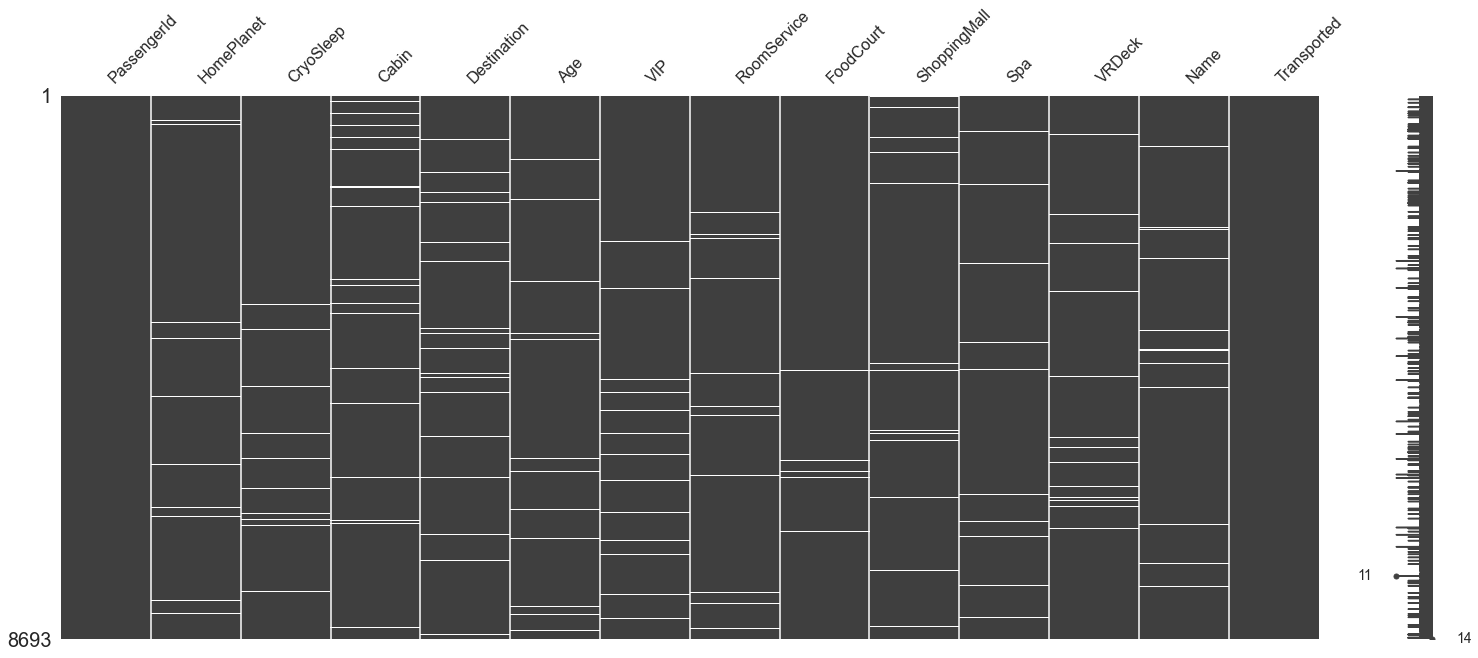

In [262]:
msno.matrix(df)

## Drop features

In [263]:
df.drop(columns=[PID, NAME], inplace=True)
df.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True


## Target | Transported

In [264]:
df.rename(columns={TRANSPORTED: TARGET}, inplace=True)
df.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True


In [265]:
df[TARGET].value_counts()

True     4378
False    4315
Name: Target, dtype: int64

In [266]:
df[TARGET] = df[TARGET].map(TRUE_FALSE_MAP)
df[TARGET].value_counts()

1    4378
0    4315
Name: Target, dtype: int64

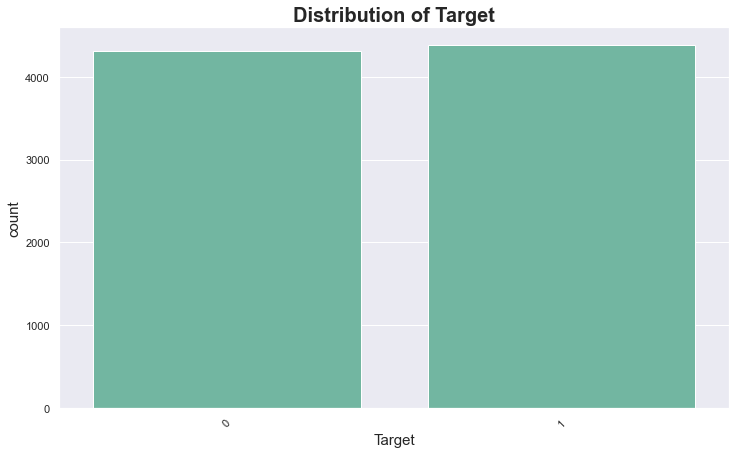

In [267]:
plot_dist_cat(TARGET)

In [268]:
###############################################################
#   Oversample the target (BorderlineSMOTE)
###############################################################

## General Preprocessing

In [269]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [270]:
df[CRYO_SLEEP] = df[CRYO_SLEEP].map(TRUE_FALSE_MAP)
df[VIP] = df[VIP].map(TRUE_FALSE_MAP)

display(
    df[CRYO_SLEEP].value_counts(dropna=False),
    df[VIP].value_counts(dropna=False)
)

0.0    5439
1.0    3037
NaN     217
Name: CryoSleep, dtype: int64

0.0    8291
NaN     203
1.0     199
Name: VIP, dtype: int64

In [271]:
df[CABIN].str[0].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [272]:
df[CABIN] = df[CABIN].str[0]
df[CABIN].value_counts(dropna=False)

F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: Cabin, dtype: int64

In [273]:
df[DESTINATION].value_counts(dropna=False)

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: Destination, dtype: int64

## HomePlanet

In [274]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
0,Europa,0.0,B,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Earth,0.0,F,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1
2,Europa,0.0,A,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,0.0,A,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,0.0,F,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1


In [275]:
df[HOME_PLANET].isna().sum()

201

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

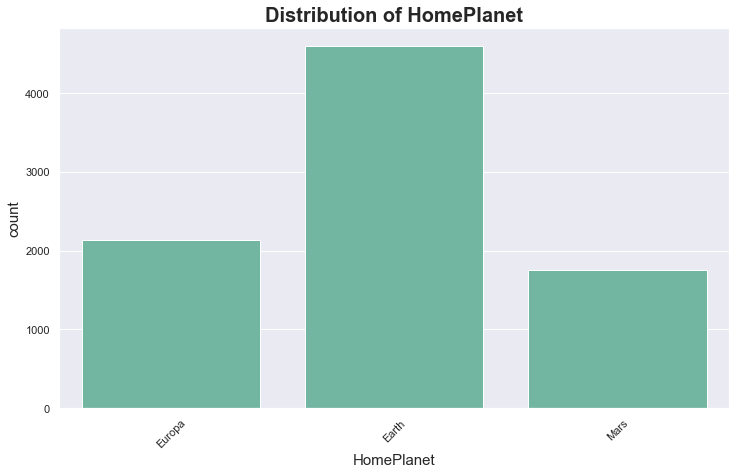

In [276]:
plot_dist_cat(HOME_PLANET)
df[HOME_PLANET].value_counts()

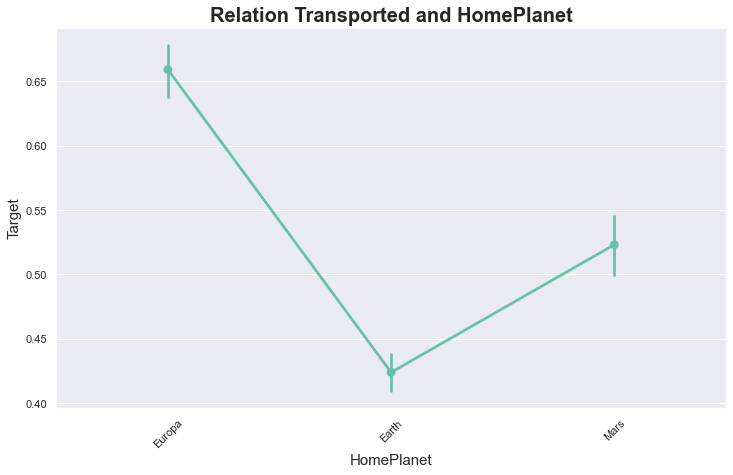

In [277]:
plot_target_relation_cat(HOME_PLANET)

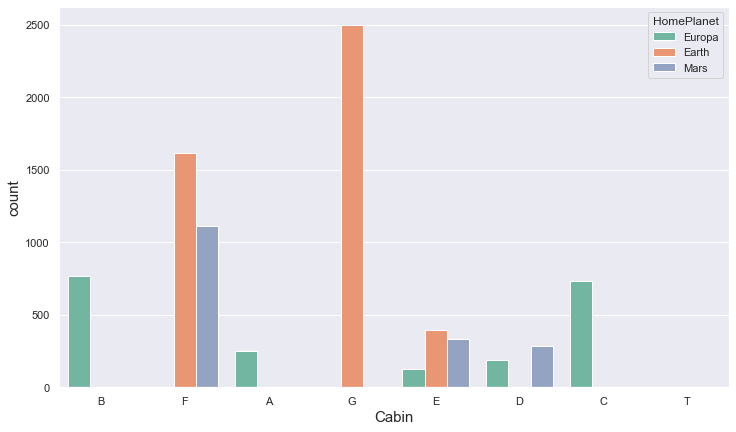

In [278]:
sns.countplot(x=CABIN, hue=HOME_PLANET, data=df);

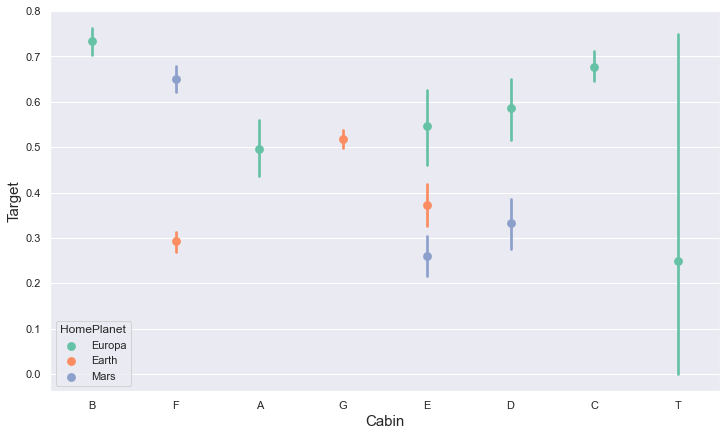

In [279]:
sns.pointplot(x=CABIN, y=TARGET, data=df, hue=HOME_PLANET, linestyles="");

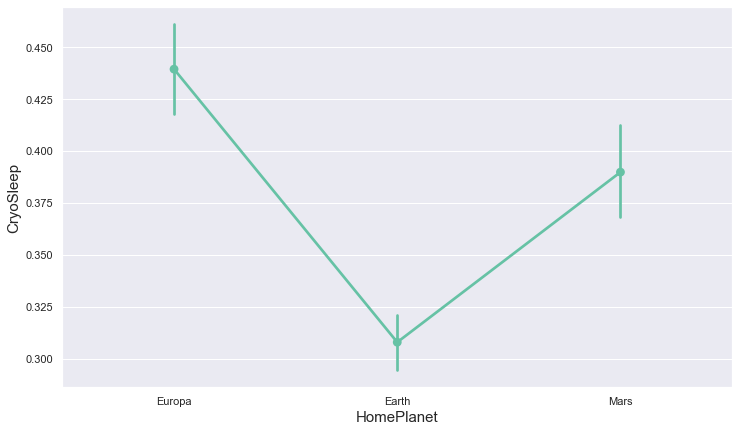

In [280]:
sns.pointplot(x=HOME_PLANET, y=CRYO_SLEEP, data=df);

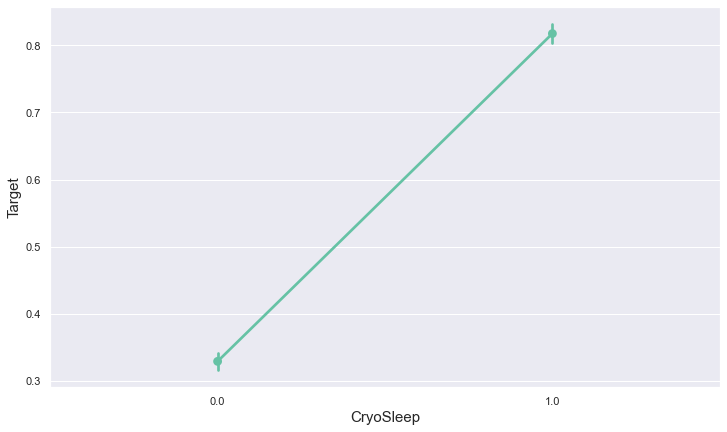

In [281]:
sns.pointplot(x=CRYO_SLEEP, y=TARGET, data=df);

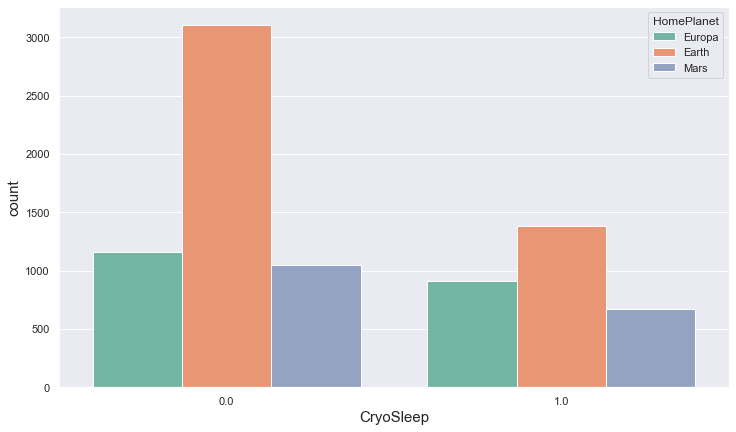

In [282]:
sns.countplot(x=CRYO_SLEEP, hue=HOME_PLANET, data=df);

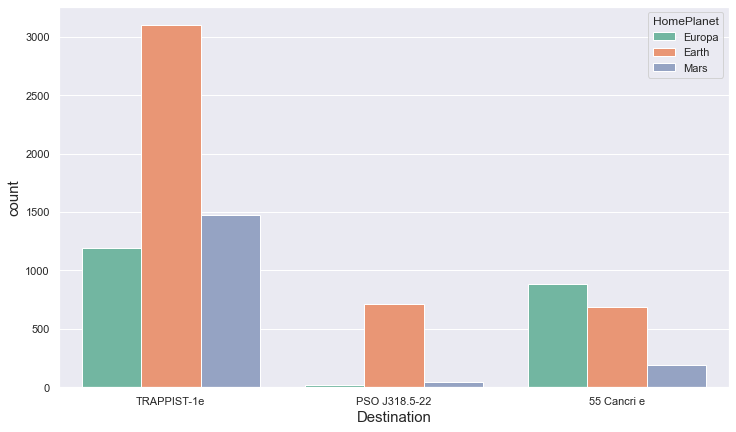

In [283]:
sns.countplot(x=DESTINATION, hue=HOME_PLANET, data=df);

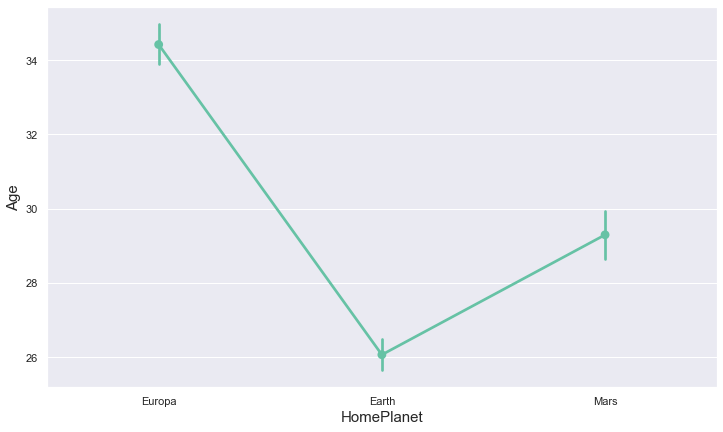

In [284]:
sns.pointplot(x=HOME_PLANET, y=AGE, data=df);

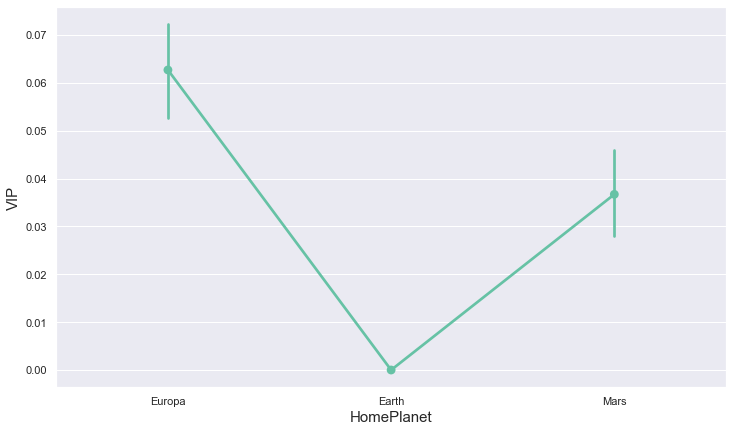

In [285]:
sns.pointplot(x=HOME_PLANET, y=VIP, data=df);

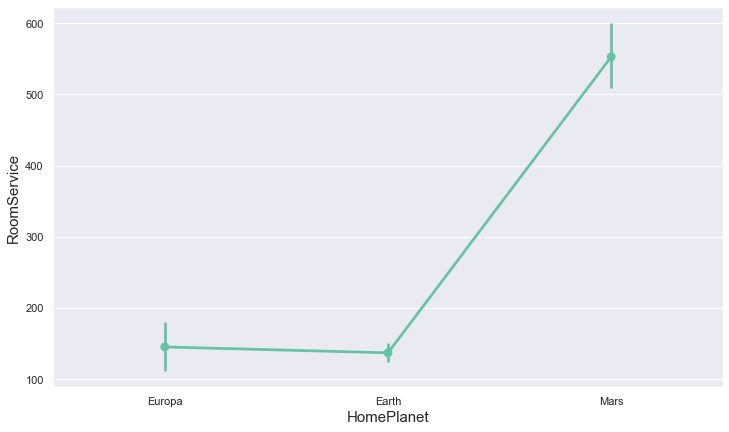

In [286]:
sns.pointplot(x=HOME_PLANET, y=ROOM_SERVICE, data=df);

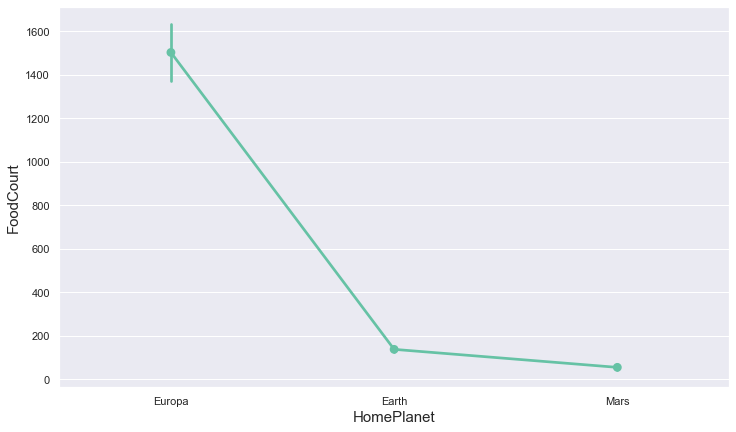

In [287]:
sns.pointplot(x=HOME_PLANET, y=FOOD_COURT, data=df);

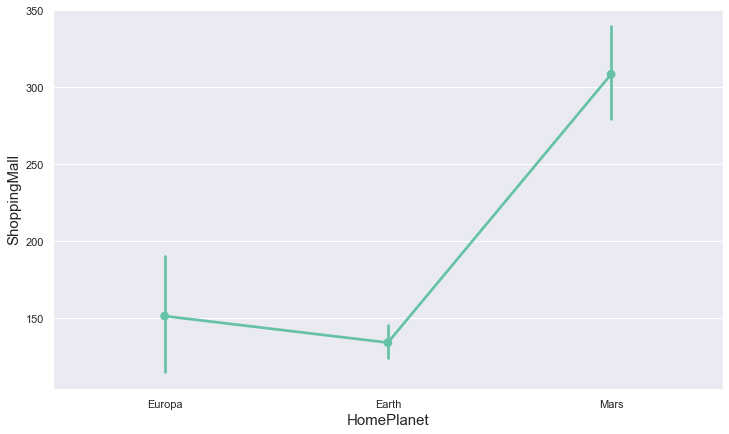

In [288]:
sns.pointplot(x=HOME_PLANET, y=SHOPPING_MALL, data=df);

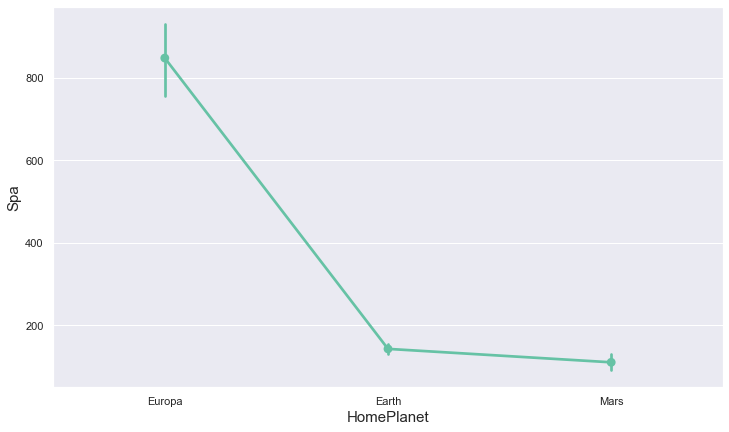

In [289]:
sns.pointplot(x=HOME_PLANET, y=SPA, data=df);

<AxesSubplot:xlabel='HomePlanet', ylabel='VRDeck'>

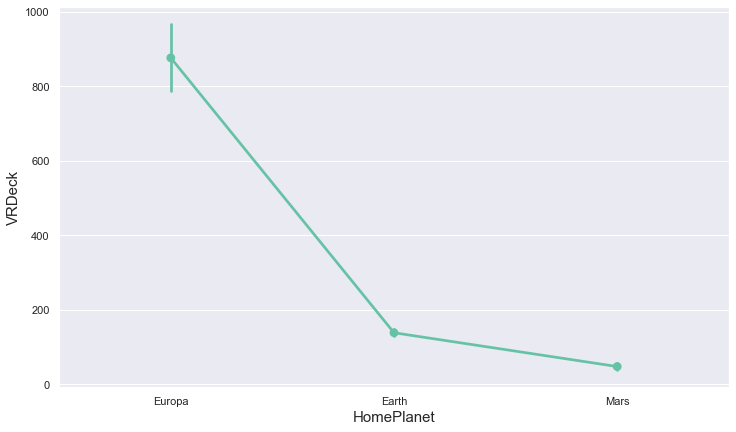

In [290]:
sns.pointplot(x=HOME_PLANET, y=VR_DECK, data=df)

In [291]:
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
225,NaN,0.0,F,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,0
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,NaN,0.0,F,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1
8674,NaN,0.0,F,TRAPPIST-1e,13.0,0.0,39.0,0.0,1085.0,24.0,0.0,0


In [292]:
earth_condition1 = (df[HOME_PLANET].isna()) & (df[CABIN] == "G")
df.loc[earth_condition1, HOME_PLANET] = "Earth"
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
225,NaN,0.0,F,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,0
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,NaN,0.0,F,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1


In [293]:
earth_condition2 = (df[HOME_PLANET].isna()) & (df[CABIN] == "F") & (df[TARGET] == 0) & (df[CRYO_SLEEP] == 0) & (df[DESTINATION] == "PSO J318.5-22")
df.loc[earth_condition2, HOME_PLANET] = "Earth"
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
225,NaN,0.0,F,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,0
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,NaN,0.0,F,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1


In [294]:
mars_condition1 = (df[HOME_PLANET].isna()) & (df[CABIN] == "F") & (df[TARGET] == 0) & (df[CRYO_SLEEP] == 0) & (df[VIP] == 1)
df.loc[mars_condition1, HOME_PLANET] = "Mars"
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
225,NaN,0.0,F,TRAPPIST-1e,18.0,0.0,313.0,1.0,691.0,283.0,0.0,0
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,NaN,0.0,F,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1


In [295]:
df.pivot_table(index=HOME_PLANET, values=ROOM_SERVICE)

,RoomService
HomePlanet,
Earth,135.712908
Europa,145.231981
Mars,554.634415


In [296]:
df.loc[df[HOME_PLANET] == "Earth", ROOM_SERVICE].quantile(q=[0.8])

0.8    102.0
Name: RoomService, dtype: float64

In [297]:
mars_condition2 = (
    (df[HOME_PLANET].isna()) & 
    (df[CABIN] == "F") & 
    (df[TARGET] == 0) & 
    (df[CRYO_SLEEP] == 0) &
    (df[ROOM_SERVICE] > 100)
)
df.loc[mars_condition2, HOME_PLANET] = "Mars"
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
365,NaN,1.0,D,55 Cancri e,32.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0
8666,NaN,0.0,F,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,1


In [298]:
df.loc[df[HOME_PLANET] == "Earth", SHOPPING_MALL].quantile(q=[0.8])


0.8    98.0
Name: ShoppingMall, dtype: float64

In [299]:
mars_condition3 = (
    (df[HOME_PLANET].isna()) & 
    (df[CABIN] == "F") & 
    (df[TARGET] == 0) & 
    (df[CRYO_SLEEP] == 0) &
    (df[SHOPPING_MALL] > 100)
)
df.loc[mars_condition3, HOME_PLANET] = "Mars"
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
113,NaN,0.0,A,TRAPPIST-1e,39.0,0.0,0.0,2344.0,0.0,65.0,6898.0,0
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
365,NaN,1.0,D,55 Cancri e,32.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8468,NaN,1.0,F,TRAPPIST-1e,25.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8515,NaN,0.0,E,TRAPPIST-1e,25.0,0.0,1258.0,0.0,22.0,19.0,0.0,0
8613,NaN,0.0,E,55 Cancri e,53.0,0.0,0.0,4017.0,0.0,13.0,3147.0,0


In [300]:
display(
    df.loc[df[HOME_PLANET] == "Earth", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Mars", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Europa", [FOOD_COURT, SPA, VR_DECK]].quantile(q=[0.8])
)

,FoodCourt,Spa,VRDeck
0.8,100.0,101.0,107.2


,FoodCourt,Spa,VRDeck
0.8,0.0,20.0,0.0


,FoodCourt,Spa,VRDeck
0.8,2641.4,1080.0,1150.0


In [301]:
europa_condition1 = (
    (df[HOME_PLANET].isna()) & 
    (
        (df[FOOD_COURT] > 105) | 
        (df[SPA] > 105) | 
        (df[VR_DECK] > 105)
    )
)
df.loc[europa_condition1, HOME_PLANET] = "Europa" 
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
365,NaN,1.0,D,55 Cancri e,32.0,1.0,0.0,0.0,0.0,0.0,0.0,1
438,NaN,1.0,F,TRAPPIST-1e,36.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8295,NaN,1.0,F,TRAPPIST-1e,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8353,NaN,1.0,F,TRAPPIST-1e,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8468,NaN,1.0,F,TRAPPIST-1e,25.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8489,NaN,1.0,F,TRAPPIST-1e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [302]:
display(
    df.loc[df[HOME_PLANET] == "Earth", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Mars", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8]),
    df.loc[df[HOME_PLANET] == "Europa", [SHOPPING_MALL, ROOM_SERVICE]].quantile(q=[0.8])
)

,ShoppingMall,RoomService
0.8,98.0,102.0


,ShoppingMall,RoomService
0.8,575.2,1054.4


,ShoppingMall,RoomService
0.8,0.0,0.0


In [303]:
mars_condition4 = (
    (df[HOME_PLANET].isna()) & 
    (
        (df[SHOPPING_MALL] > 100) | 
        (df[ROOM_SERVICE] > 105)
    )
)
df.loc[mars_condition4, HOME_PLANET] = "Mars" 
df[df[HOME_PLANET].isna()].shape

(49, 12)

In [304]:
df[(df[HOME_PLANET].isna()) & (df[TARGET] == 0)].shape,
df[(df[HOME_PLANET].isna()) & (df[TARGET] == 1)].shape

(47, 12)

In [305]:
df[df[HOME_PLANET].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Target
59,NaN,1.0,E,TRAPPIST-1e,33.0,0.0,0.0,0.0,NaN,0.0,0.0,1
186,NaN,1.0,D,55 Cancri e,24.0,0.0,0.0,0.0,NaN,0.0,0.0,1
234,NaN,1.0,C,55 Cancri e,54.0,0.0,0.0,0.0,0.0,0.0,0.0,1
365,NaN,1.0,D,55 Cancri e,32.0,1.0,0.0,0.0,0.0,0.0,0.0,1
438,NaN,1.0,F,TRAPPIST-1e,36.0,0.0,0.0,0.0,0.0,0.0,0.0,1
471,NaN,1.0,B,55 Cancri e,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1
481,NaN,1.0,F,TRAPPIST-1e,35.0,0.0,0.0,0.0,0.0,0.0,0.0,1
501,NaN,1.0,C,55 Cancri e,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1
737,NaN,1.0,E,TRAPPIST-1e,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1
807,NaN,1.0,A,55 Cancri e,38.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
#########################
# Wenn Target = False & Destination = PSO-j318.5-22 & Cryo-Sleep=True & Cabin=G

##########################